# Adaption to new classes
project 7 by Guanzhao Wang, Haochen Wu, Yukai Wang

### Abstact outline:
In this project, the goal is to find a way which combines unsupervised and supervised method. The baselines are the methods to train the model with supervised categories. The unsupervised section follows. The primary goal is to train a model that is able to classify all the categories (labeled and unlabeled).

A classification model is trained under labeled categories on Fashion-MNIST dataset. Then, new categories are added without labels. There are several unsupervised clustering methods implemented and compared. They are Kmeans, Kmeans with PCA, Kmeans with Auto Encoder, Gaussian Mixture, Gaussian Mixture with PCA and Gaussian Mixture with Auto Encoder. These unlabeled categories will be labeled by the clustering methods and concatenated with other categories. The classification model will be trained again on the full dataset which contains the pre-labeled categories and new categories just labeled by the unsupervised methods. The result of the classification is drawn between all eight methods and an conclusion is given at the end.

### Teammates:
- Guanzhao Wang:

- Haochen Wu:

- Yukai Wang:

### Library
Several library functions are implemented. They are imported in the front of the next code block. The externel libraries are imported in the behind of the next block.

Our own code library is implemented in the <em>mylib</em> subdirectory. All the files in the library are listed below in an order used to train models:
- <strong>dataloader</strong>: 
>Include customFashionMNIST class for loading custom Fashion-MNIST dataset. Dataloader functions: <br><code>getTrainValidateLoaders(include_labels=range(10), transform=None, batch_size=64, split = 0.9, num_workers=1, mode=7, USE_GPU=False)</code>
     <br><code>getTestLoaders(include_labels=range(10), transform=None, batch_size=64, num_workers=1, USE_GPU=False)</code>
- <strong>transform</strong>: 
>Define transform used for dataloader. 
- <strong>model</strong>: 
>Include several Neural Networks. A normal CNN: <code>Net()</code>, <br>A ResNet model: <code>CustomFashionResNet()</code>, <br>clustering model: <code>Autoencoder()</code>
- <strong>loss</strong>: 
>Include loss functions. <br>crossEntropyLoss for training: <code>loss_function()</code>; <br>loss for autoencoder: <code>autoencoder_loss()</code>
- <strong>train</strong>: 
>Train functions for models and autoencoder: <br><code>train(train_val_loaders, net, loss_function, optimizer, USE_GPU, checkpoint_path)</code> and <br><code>autoencoder_train(train_loader, net, loss_function, optimizer, USE_GPU)</code>
- <strong>eval</strong>: 
>Include validation function: <code>validate(val_loader, net, loss, USE_GPU)</code>
- <strong>clustering</strong>: 
>Unsupervised method for labeling data. <code>label_data(unlabeled_data, labels, mode=0, USE_GPU=False)</code>
- <strong>report</strong>: 
>Two report functions. <br>Training report: <code>report_epoch_summary(eval_metrics)</code>; <br>Summary report: <code>report_summary(mode_metrics, mode_description)</code>

Externel libraries included:
- <strong>numpy</strong>:
- <strong>matplotlib</strong>: 
><br><code>matplotlib.pyplt</code>
- <strong>torch</strong>:
- <strong>torchvision</strong>:
- <strong>sklearn</strong>: 
>in clustering, for Kmean and GaussianMixture, confusion_matrix
- <strong>pl_bolts.models.autoencoders</strong>: 
><code>pip install lightning-bolts</code>

In [1]:
from mylibs.dataloader import getTrainValidateLoaders, getTestLoaders
from mylibs.train import train
from mylibs.eval import validate
from mylibs.model import Net, CustomFashionResNet
from mylibs.loss import loss_function
from mylibs.report import report_epoch_summary, report_summary
from mylibs.transform import transform_aug, transform_t, transform_n

import torch
from torchvision import transforms
import os

C:\Users\kewa9\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:62: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [3]:
USE_GPU = True
BATCH_SIZE = 64
EPOCH = 30
NUM_WORKERS = 2
K = 7

In [7]:
device = torch.device("cuda" if USE_GPU else "cpu")

transform = transform_aug

mode_description = {0: "clustering: kmeans",
                    1: "clustering: kmeans with PCA",
                    2: "clustering: kmeans with Auto Encoder",
                    3: "clustering: Gaussian Mixture",
                    4: "clustering: Gaussian Mixture with PCA",
                    5: "clustering: Gaussian Mixture with Auto Encoder",
                    6: "use only labeled data",
                    7: "use full FasionMNIST data",
                   }

mode_description_short = {0: "Kmeans",
                          1: "Kmeans with PCA",
                          2: "Kmeans with Auto Encoder",
                          3: "Gaussian Mixture",
                          4: "Gaussian Mixture with PCA",
                          5: "Gaussian Mixture with Auto Encoder",
                          6: "Labeled data only",
                          7: "Full FasionMNIST",
                         }

mode_metrics = {}

In [8]:
def whole_flow(mode, useResnet):
    global mode_metrics
    print(f"Getting train and validate dataloaders for mode {mode}: {mode_description[mode]}")
    train_val_loaders = getTrainValidateLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, split=0.9, num_workers=NUM_WORKERS, mode=mode, USE_GPU=USE_GPU)
    if useResnet:
        model = CustomFashionResNet(color_scale = 1, num_classes = 10).to(device)
    else:
        model = Net().to(device)
    optimizer = torch.optim.Adadelta(model.parameters(), lr=0.01)
    eval_metrics = []

    model_name = "ResNet" if useResnet else "Net"
    checkpoint_path = f"./checkpoint/mode_{mode}/{model_name}"
    os.makedirs(checkpoint_path, exist_ok=True)
    
    print(f"Start Training... {model_name}")
    # scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, EPOCH+1):
        eval_metric = train(train_val_loaders, model, loss_function, optimizer, USE_GPU, f"{checkpoint_path}/epoch_{epoch}.pt")
        eval_metrics.append(eval_metric)
        print(f"Epoch: {epoch}")
        print(f"\tTrain      - Loss: {eval_metric['train']['loss']:.4f} Accuracy: {eval_metric['train']['acc']:.4f} F1_score: {eval_metric['train']['f1']:.4f}")
        print(f"\tValidation - Loss: {eval_metric['val']['loss']:.4f} Accuracy: {eval_metric['val']['acc']:.4f} F1_score: {eval_metric['val']['f1']:.4f}")

    report_epoch_summary(eval_metrics)
    
    all_val_f1 = [x['val']['f1'] for x in eval_metrics]
    best_epoch = all_val_f1.index(max(all_val_f1)) + 1
    print(f"Loading model at epoch {best_epoch} for best validation f1")
    checkpoint = torch.load(f"{checkpoint_path}/epoch_{epoch}.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    print("Preparing test loaders")
    labeled_test_loader, unlabeled_test_loader, test_loader = getTestLoaders(include_labels=range(K), transform=transform, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, USE_GPU=USE_GPU)
    
    model.eval()
    eval_metric = validate(labeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on labelled test set  : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(unlabeled_test_loader, model, loss_function, USE_GPU)
    print(f"Result on unlabelled test set: Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")

    eval_metric = validate(test_loader, model, loss_function, USE_GPU)
    print(f"Result on full test set      : Loss: {eval_metric['loss']:.4f} Accuracy: {eval_metric['acc']:.4f} F1_score: {eval_metric['f1']:.4f}")
    
    mode_metrics[mode] = eval_metrics


## Baseline #1, use only first K-class labelled data to train

In [9]:
whole_flow(6, True)

Getting train and validate dataloaders for mode 6: use only labeled data
Start Training... ResNet
Epoch: 1
	Train      - Loss: 1.1380 Accuracy: 0.6209 F1_score: 0.6286
	Validation - Loss: 0.7332 Accuracy: 0.7419 F1_score: 0.7434


KeyboardInterrupt: 

## Baseline #2, use full Fashion-MNIST dataset to train

Getting train and validate dataloaders for mode 7: use full FasionMNIST data
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7337 Accuracy: 0.7394 F1_score: 0.7387
	Validation - Loss: 0.5090 Accuracy: 0.8132 F1_score: 0.8120
Epoch: 2
	Train      - Loss: 0.4459 Accuracy: 0.8357 F1_score: 0.8348
	Validation - Loss: 0.4360 Accuracy: 0.8397 F1_score: 0.8406
Epoch: 3
	Train      - Loss: 0.3746 Accuracy: 0.8629 F1_score: 0.8625
	Validation - Loss: 0.4041 Accuracy: 0.8495 F1_score: 0.8465
Epoch: 4
	Train      - Loss: 0.3298 Accuracy: 0.8779 F1_score: 0.8775
	Validation - Loss: 0.3855 Accuracy: 0.8625 F1_score: 0.8626
Epoch: 5
	Train      - Loss: 0.2965 Accuracy: 0.8899 F1_score: 0.8896
	Validation - Loss: 0.3695 Accuracy: 0.8665 F1_score: 0.8663
Epoch: 6
	Train      - Loss: 0.2670 Accuracy: 0.9006 F1_score: 0.9004
	Validation - Loss: 0.3743 Accuracy: 0.8673 F1_score: 0.8678
Epoch: 7
	Train      - Loss: 0.2458 Accuracy: 0.9080 F1_score: 0.9078
	Validation - Loss: 0.3681 Accuracy: 0.869

<Figure size 432x288 with 0 Axes>

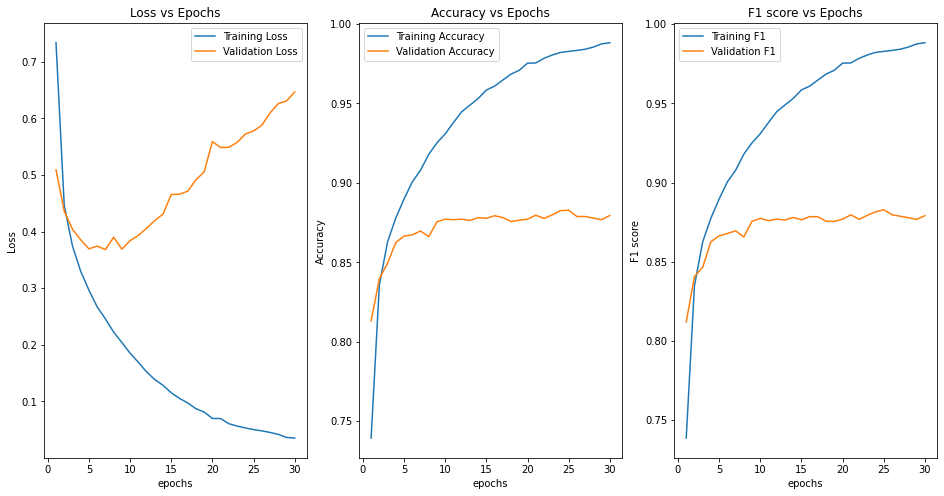

Loading model at epoch 25 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.8179 Accuracy: 0.8473 F1_score: 0.8506
Result on unlabelled test set: Loss: 0.2337 Accuracy: 0.9513 F1_score: 0.9630
Result on full test set      : Loss: 0.6383 Accuracy: 0.8785 F1_score: 0.8784


In [6]:
whole_flow(7, True)

# Label new categories by clustering

- label the dataset under different clustering methods
- compare acuracy on the test set

## Approach #1, use KMeans to compute label for unlabelled data

Getting train and validate dataloaders for mode 0: clustering: kmeans
Labeling unlabeled data...
Labeling accuracy: 0.8801111111111111
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.6958 Accuracy: 0.7597 F1_score: 0.7601
	Validation - Loss: 0.4954 Accuracy: 0.8180 F1_score: 0.8153
Epoch: 2
	Train      - Loss: 0.4186 Accuracy: 0.8487 F1_score: 0.8482
	Validation - Loss: 0.4088 Accuracy: 0.8520 F1_score: 0.8517
Epoch: 3
	Train      - Loss: 0.3536 Accuracy: 0.8696 F1_score: 0.8693
	Validation - Loss: 0.3807 Accuracy: 0.8607 F1_score: 0.8587
Epoch: 4
	Train      - Loss: 0.3142 Accuracy: 0.8842 F1_score: 0.8839
	Validation - Loss: 0.3763 Accuracy: 0.8622 F1_score: 0.8625
Epoch: 5
	Train      - Loss: 0.2825 Accuracy: 0.8958 F1_score: 0.8956
	Validation - Loss: 0.3682 Accuracy: 0.8692 F1_score: 0.8679
Epoch: 6
	Train      - Loss: 0.2581 Accuracy: 0.9049 F1_score: 0.9047
	Validation - Loss: 0.3594 Accuracy: 0.8773 F1_score: 0.8764
Epoch: 7
	Train      - Loss: 0.2358 Accuracy: 0.9142 F

<Figure size 432x288 with 0 Axes>

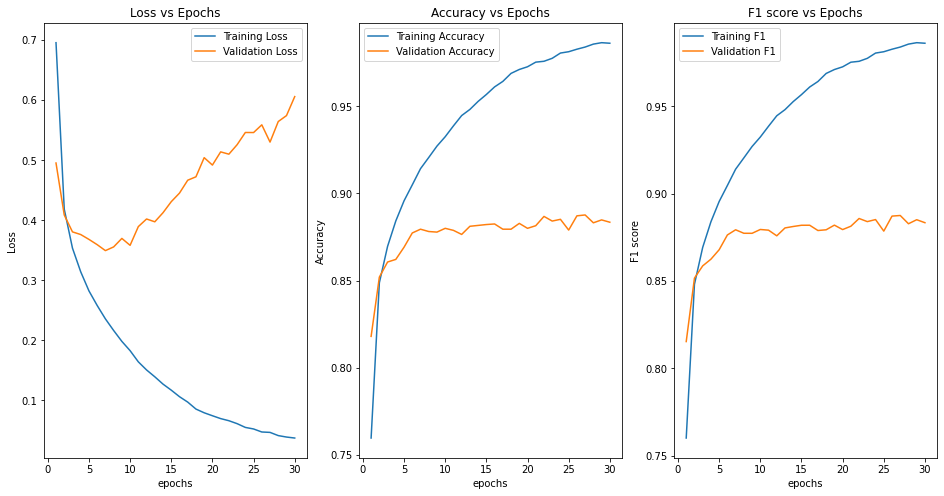

Loading model at epoch 27 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.7751 Accuracy: 0.8571 F1_score: 0.8611
Result on unlabelled test set: Loss: 1.2076 Accuracy: 0.8643 F1_score: 0.8764
Result on full test set      : Loss: 0.8993 Accuracy: 0.8593 F1_score: 0.8602


In [7]:
whole_flow(0, True)

## Approach #2, use KMeans with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 1: clustering: kmeans with PCA
Labeling unlabeled data...
Labeling accuracy: 0.8809444444444444
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7242 Accuracy: 0.7436 F1_score: 0.7432
	Validation - Loss: 0.4806 Accuracy: 0.8263 F1_score: 0.8255
Epoch: 2
	Train      - Loss: 0.4284 Accuracy: 0.8434 F1_score: 0.8426
	Validation - Loss: 0.4125 Accuracy: 0.8485 F1_score: 0.8483
Epoch: 3
	Train      - Loss: 0.3620 Accuracy: 0.8675 F1_score: 0.8670
	Validation - Loss: 0.3912 Accuracy: 0.8567 F1_score: 0.8580
Epoch: 4
	Train      - Loss: 0.3202 Accuracy: 0.8819 F1_score: 0.8815
	Validation - Loss: 0.3701 Accuracy: 0.8707 F1_score: 0.8696
Epoch: 5
	Train      - Loss: 0.2884 Accuracy: 0.8941 F1_score: 0.8939
	Validation - Loss: 0.3596 Accuracy: 0.8732 F1_score: 0.8728
Epoch: 6
	Train      - Loss: 0.2599 Accuracy: 0.9041 F1_score: 0.9040
	Validation - Loss: 0.3595 Accuracy: 0.8763 F1_score: 0.8750
Epoch: 7
	Train      - Loss: 0.2369 Accuracy:

<Figure size 432x288 with 0 Axes>

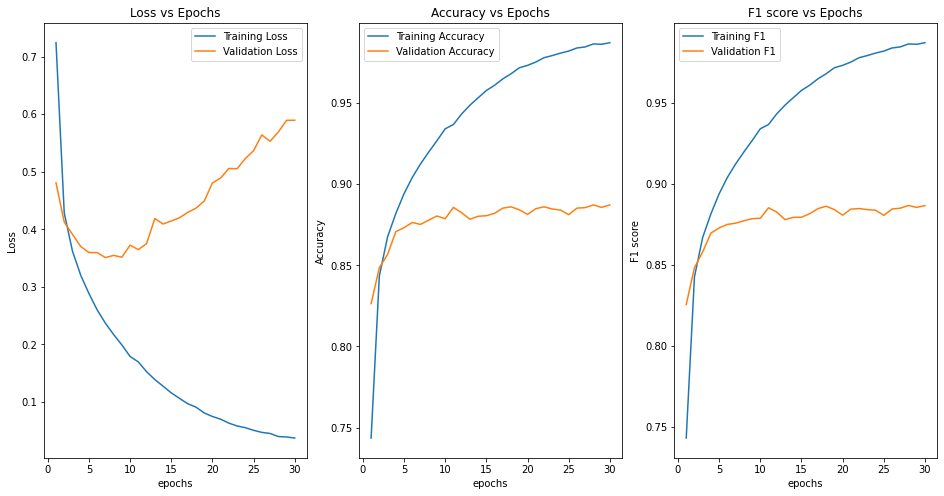

Loading model at epoch 28 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.7907 Accuracy: 0.8480 F1_score: 0.8523
Result on unlabelled test set: Loss: 1.0387 Accuracy: 0.8750 F1_score: 0.8845
Result on full test set      : Loss: 0.8660 Accuracy: 0.8561 F1_score: 0.8573


In [8]:
whole_flow(1, True)

## Approach #3, use KMeans with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 2: clustering: kmeans with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...
Epoch: 1 Loss: {'loss': 0.03462433258891106}
Epoch: 2 Loss: {'loss': 0.02520705736776193}
Epoch: 3 Loss: {'loss': 0.023298930461208026}
Epoch: 4 Loss: {'loss': 0.022328879150748254}
Epoch: 5 Loss: {'loss': 0.021523506488402684}
Epoch: 6 Loss: {'loss': 0.02115795686443647}
Epoch: 7 Loss: {'loss': 0.020942500866452853}
Epoch: 8 Loss: {'loss': 0.02077845316628615}
Epoch: 9 Loss: {'loss': 0.02063609689573447}
Epoch: 10 Loss: {'loss': 0.020546441688636938}
Labeling accuracy: 0.33905555555555555
Start Training... ResNet
Epoch: 1
	Train      - Loss: 1.0386 Accuracy: 0.5982 F1_score: 0.5745
	Validation - Loss: 0.7781 Accuracy: 0.6778 F1_score: 0.6519
Epoch: 2
	Train      - Loss: 0.7385 Accuracy: 0.6981 F1_score: 0.6625
	Validation - Loss: 0.7022 Accuracy: 0.7070 F1_score: 0.6760
Epoch: 3
	Train      - Loss: 0.6673 Accuracy: 0.7217 F1_score: 0.6842
	Validat

<Figure size 432x288 with 0 Axes>

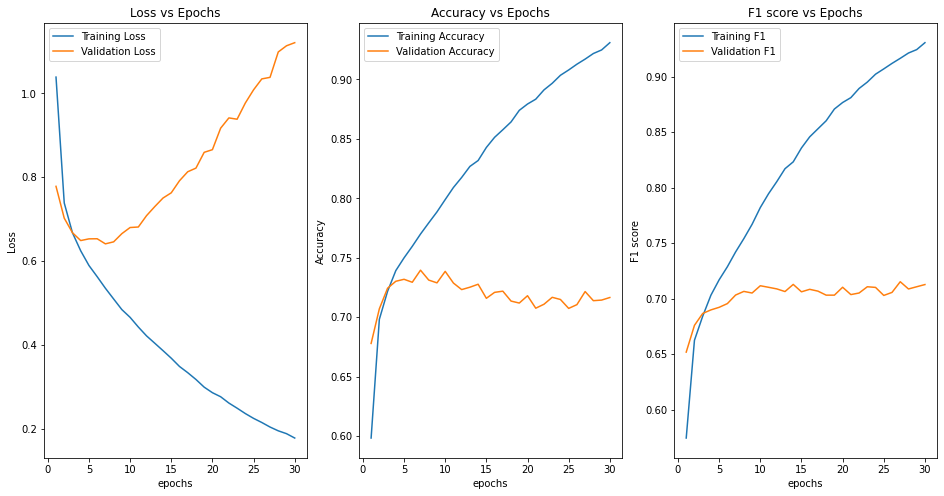

Loading model at epoch 27 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.7891 Accuracy: 0.8444 F1_score: 0.8483
Result on unlabelled test set: Loss: 2.3563 Accuracy: 0.3670 F1_score: 0.3541
Result on full test set      : Loss: 1.2611 Accuracy: 0.7012 F1_score: 0.6962


In [12]:
whole_flow(2, True)

## Approach #4, use Gaussian Mixture to compute label for unlabelled data

Getting train and validate dataloaders for mode 3: clustering: Gaussian Mixture
Labeling unlabeled data...
Labeling accuracy: 0.8328888888888889
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7479 Accuracy: 0.7346 F1_score: 0.7337
	Validation - Loss: 0.5076 Accuracy: 0.8127 F1_score: 0.8108
Epoch: 2
	Train      - Loss: 0.4500 Accuracy: 0.8349 F1_score: 0.8338
	Validation - Loss: 0.4239 Accuracy: 0.8393 F1_score: 0.8393
Epoch: 3
	Train      - Loss: 0.3779 Accuracy: 0.8627 F1_score: 0.8623
	Validation - Loss: 0.3912 Accuracy: 0.8558 F1_score: 0.8565
Epoch: 4
	Train      - Loss: 0.3324 Accuracy: 0.8784 F1_score: 0.8781
	Validation - Loss: 0.3678 Accuracy: 0.8638 F1_score: 0.8639
Epoch: 5
	Train      - Loss: 0.2985 Accuracy: 0.8884 F1_score: 0.8883
	Validation - Loss: 0.3605 Accuracy: 0.8698 F1_score: 0.8694
Epoch: 6
	Train      - Loss: 0.2713 Accuracy: 0.9000 F1_score: 0.8998
	Validation - Loss: 0.3528 Accuracy: 0.8702 F1_score: 0.8700
Epoch: 7
	Train      - Loss: 0.2432 Accuracy

<Figure size 432x288 with 0 Axes>

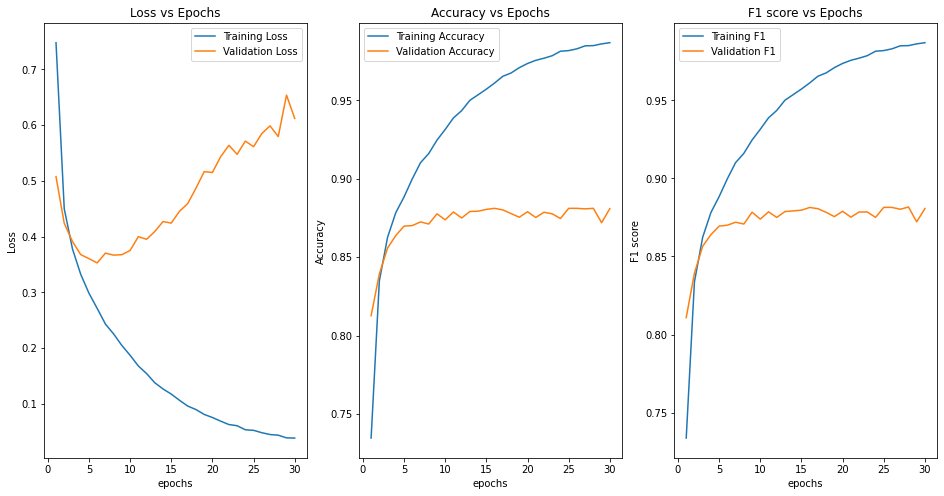

Loading model at epoch 28 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.8378 Accuracy: 0.8484 F1_score: 0.8520
Result on unlabelled test set: Loss: 2.1242 Accuracy: 0.8107 F1_score: 0.8167
Result on full test set      : Loss: 1.2275 Accuracy: 0.8371 F1_score: 0.8358


In [9]:
whole_flow(3, True)

## Approach #5, use Gaussian Mixture with PCA to compute label for unlabelled data

Getting train and validate dataloaders for mode 4: clustering: Gaussian Mixture with PCA
Labeling unlabeled data...
Labeling accuracy: 0.6936111111111111
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.7249 Accuracy: 0.7433 F1_score: 0.7434
	Validation - Loss: 0.5231 Accuracy: 0.8105 F1_score: 0.8101
Epoch: 2
	Train      - Loss: 0.4496 Accuracy: 0.8346 F1_score: 0.8338
	Validation - Loss: 0.4367 Accuracy: 0.8438 F1_score: 0.8422
Epoch: 3
	Train      - Loss: 0.3713 Accuracy: 0.8632 F1_score: 0.8627
	Validation - Loss: 0.4033 Accuracy: 0.8565 F1_score: 0.8547
Epoch: 4
	Train      - Loss: 0.3279 Accuracy: 0.8793 F1_score: 0.8789
	Validation - Loss: 0.3908 Accuracy: 0.8602 F1_score: 0.8604
Epoch: 5
	Train      - Loss: 0.2962 Accuracy: 0.8921 F1_score: 0.8918
	Validation - Loss: 0.3735 Accuracy: 0.8690 F1_score: 0.8684
Epoch: 6
	Train      - Loss: 0.2710 Accuracy: 0.9007 F1_score: 0.9005
	Validation - Loss: 0.3734 Accuracy: 0.8665 F1_score: 0.8663
Epoch: 7
	Train      - Loss: 0.2479

<Figure size 432x288 with 0 Axes>

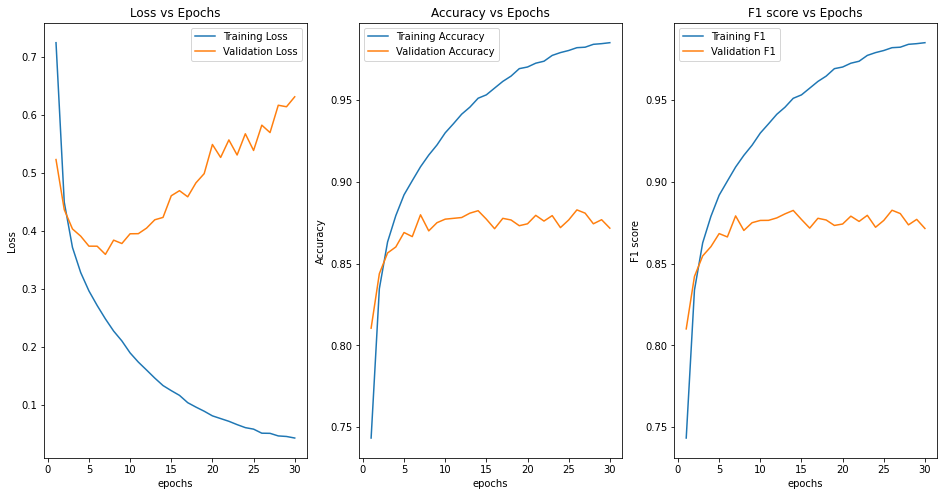

Loading model at epoch 26 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.7986 Accuracy: 0.8506 F1_score: 0.8546
Result on unlabelled test set: Loss: 4.1157 Accuracy: 0.6867 F1_score: 0.6757
Result on full test set      : Loss: 1.8028 Accuracy: 0.8014 F1_score: 0.7963


In [10]:
whole_flow(4, True)

## Approach #6, use Gaussian Mixture with Auto Encoder to compute label for unlabelled data

Getting train and validate dataloaders for mode 5: clustering: Gaussian Mixture with Auto Encoder
Labeling unlabeled data...
Training Auto Encoder...
Epoch: 1 Loss: {'loss': 0.04427983486950397}
Epoch: 2 Loss: {'loss': 0.025183193121353784}
Epoch: 3 Loss: {'loss': 0.022911887882153193}
Epoch: 4 Loss: {'loss': 0.022003020531932514}
Epoch: 5 Loss: {'loss': 0.021474148216843604}
Epoch: 6 Loss: {'loss': 0.021168331001202266}
Epoch: 7 Loss: {'loss': 0.020916450763742128}
Epoch: 8 Loss: {'loss': 0.020772805062929788}
Epoch: 9 Loss: {'loss': 0.020649068599939348}
Epoch: 10 Loss: {'loss': 0.020562271422644458}
Labeling accuracy: 0.3381111111111111
Start Training... ResNet
Epoch: 1
	Train      - Loss: 0.8935 Accuracy: 0.6489 F1_score: 0.6324
	Validation - Loss: 0.6786 Accuracy: 0.7220 F1_score: 0.6957
Epoch: 2
	Train      - Loss: 0.6115 Accuracy: 0.7441 F1_score: 0.7180
	Validation - Loss: 0.6139 Accuracy: 0.7300 F1_score: 0.7183
Epoch: 3
	Train      - Loss: 0.5437 Accuracy: 0.7689 F1_score: 0.

<Figure size 432x288 with 0 Axes>

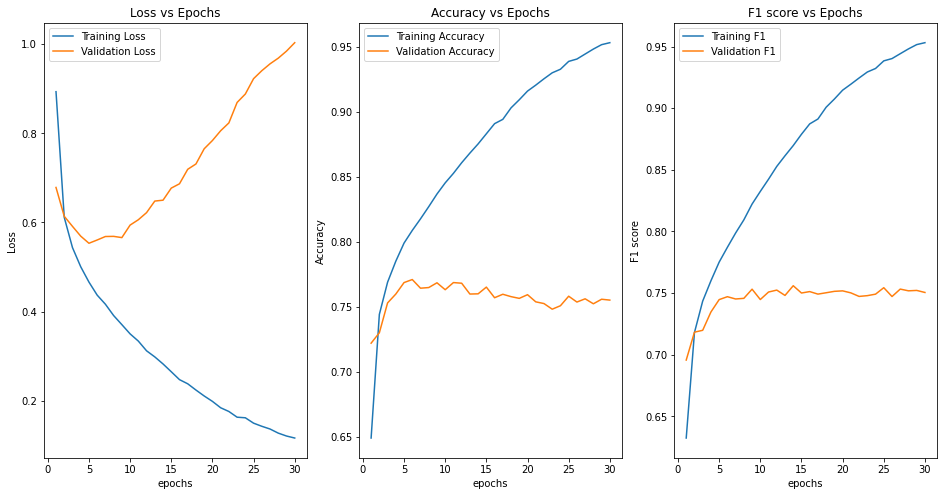

Loading model at epoch 14 for best validation f1
Preparing test loaders
Result on labelled test set  : Loss: 0.7966 Accuracy: 0.8451 F1_score: 0.8500
Result on unlabelled test set: Loss: 5.4659 Accuracy: 0.3197 F1_score: 0.2416
Result on full test set      : Loss: 2.1988 Accuracy: 0.6875 F1_score: 0.6636


In [13]:
whole_flow(5, True)

<Figure size 432x288 with 0 Axes>

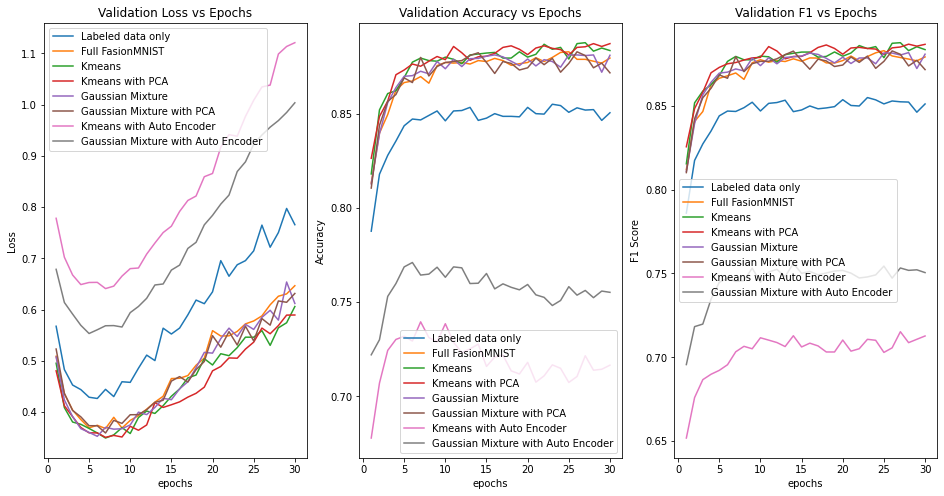

In [14]:
report_summary(mode_metrics, mode_description_short)

## Conclusion

- overview of all the methods
- eight methods are compared
- final method for best accuracy